# Project 4
## Ridge & Lasso Model of Cold Wave Final against Unseen Data
## Predicting Death

---
### Import Libraries

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for Modeling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Imports for Evaluation
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error 

from warnings import filterwarnings
filterwarnings('ignore')


### Read in Data

In [2]:
cold_final = pd.read_csv('../data/final/cold_final_dataset.csv')
cold_final.head()

,Unnamed: 0,country,subregion,region,location,temperature,start_year,start_month,total_deaths,start_date,end_date,duration_days,duration,latitude,longitude,delta_temp_C,delta_temp_std
0,0,Afghanistan,Southern Asia,Asia,"Hirat, Faryab, Jawzjan, Balkh, Samangan, Sar-e...",-25.0,2001,1,150.0,2001-01-31,2001-02-20,20 days,20,30.0,70.0,-24.856821,-8.561158
1,1,Poland,Eastern Europe,Europe,"Dolnoslaskie, Kujawsko-Pomorskie, Lodzkie, Lub...",-25.0,2001,10,270.0,2001-10-10,2002-01-20,102 days,102,50.0,20.0,-15.941674,-4.306348
2,2,Poland,Eastern Europe,Europe,"Dolnoslaskie, Kujawsko-Pomorskie, Lodzkie, Lub...",-25.0,2001,10,270.0,2001-10-10,2002-01-20,102 days,102,50.0,20.0,-15.941674,-4.306348
3,3,Peru,Latin America and the Caribbean,Americas,"Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...",-28.0,2003,7,339.0,2003-07-07,2003-08-15,39 days,39,-10.0,-70.0,-43.303703,-20.441972
4,4,South Africa,Sub-Saharan Africa,Africa,"Gauteng, Eastern Cape provinces",0.0,2007,5,22.0,2007-05-21,2007-05-27,6 days,6,-30.0,30.0,-1.690848,-0.672643


In [3]:
cold_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      41 non-null     int64  
 1   country         41 non-null     object 
 2   subregion       41 non-null     object 
 3   region          41 non-null     object 
 4   location        40 non-null     object 
 5   temperature     41 non-null     float64
 6   start_year      41 non-null     int64  
 7   start_month     41 non-null     int64  
 8   total_deaths    41 non-null     float64
 9   start_date      41 non-null     object 
 10  end_date        41 non-null     object 
 11  duration_days   41 non-null     object 
 12  duration        41 non-null     int64  
 13  latitude        41 non-null     float64
 14  longitude       41 non-null     float64
 15  delta_temp_C    41 non-null     float64
 16  delta_temp_std  41 non-null     float64
dtypes: float64(6), int64(4), object(7)
me

### Lasso Ridge Model that Performed the best with Cold_final.csv
```features = ['temperature', 'duration', 'latitude', 'longitude', 'delta_temp_std']
X = cold_final[features]
y = cold_final['total_deaths']
fit_and_evaluate_ridge_lasso(cold_final, X, y, alpha_range = np.logspace(-4, 4, 50))```

### Now will Adjust function to run on unseen data

In [4]:
def fit_and_evaluate_ridge_lasso_on_unseen(train_df, unseen_df, X, y, test_size=0.2, random_state=42, cv=5, alpha_range=None, plot=True):
    """
    train_df : pandas.DataFrame
        The full training frame with all columns available
    unseen_df: pandas.DataFrame
        The unseen test frame w/all columns available 
    X : array-like or list of column names
        Features matrix or names; can be a DataFrame already or a list of columns to select from train_df
    y : array-like or column name
        Target vector or single column name
    
    Returns:
        models: dict of fitted GridSearchCV objects
        results: dict of evaluation metrics (R2, MAE, MSE, RMSE)
    """

    if alpha_range is None:
        alpha_range = np.logspace(-4, 4, 30)  # Default grid

    # If X and y are column names, pull them from train_df
    if isinstance(X, list) and isinstance(train_df, pd.DataFrame):
        X_data = train_df[X]
    else:
        X_data = X
    if isinstance(y, str) and isinstance(train_df, pd.DataFrame):
        y_data = train_df[y]
    else:
        y_data = y

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state)

    # Ridge and Lasso Pipelines
    ridge_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Ridge())
    ])
    lasso_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", Lasso(max_iter=10000))
    ])
    param_grid = {"regressor__alpha": alpha_range}
    ridge_gs = GridSearchCV(ridge_pipe, param_grid, cv=cv, scoring='r2')
    lasso_gs = GridSearchCV(lasso_pipe, param_grid, cv=cv, scoring='r2')

    pipelines = {"Ridge (GridSearchCV)": ridge_gs, "Lasso (GridSearchCV)": lasso_gs}
    results = {}
    models = {}
    unseen_preds = {}
    
    for name, gs in pipelines.items():
        gs.fit(X_train, y_train)
        best_alpha = gs.best_params_["regressor__alpha"]
        print(f"{name} best alpha: {best_alpha:.5f}")
        
        y_train_pred = gs.predict(X_train)
        y_test_pred = gs.predict(X_test)
        # Scores and evaluation
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        cv_score = cross_val_score(gs.best_estimator_, X_train, y_train, cv=cv, scoring='r2').mean()
        print(f"{name} Training R2 Score: {train_r2:.3f}")
        print(f"{name} Test R2 Score: {test_r2:.3f}")
        print(f"{name} Cross Val Score (R2): {cv_score:.3f}")

        # Metrics
        results[name] = {
            "Best Alpha": best_alpha,
            "Train R2": train_r2,
            "Test R2": test_r2,
            "CV R2": cv_score,
            "MAE": mean_absolute_error(y_test, y_test_pred),
            "MSE": mean_squared_error(y_test, y_test_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred))
        }
        models[name] = gs

        if plot:
            plt.figure(figsize=(5,3))
            plt.scatter(y_test, y_test_pred, color='maroon', alpha=0.7, edgecolor='k')
            plt.xlabel("Actual Deaths")
            plt.ylabel("Predicted Deaths")
            plt.title(f"Actual vs Predicted Deaths (Test)- {name}")
            plt.tight_layout()
            plt.show()
            plt.savefig("../images/ridge_lasso_predicted_death_vs_actual.jpg")
    
            plt.figure(figsize=(5,3))
            residuals = y_test - y_test_pred
            plt.hist(residuals, bins=30, color='maroon')
            plt.title(f"Residuals Histogram (Test)- {name}")
            plt.xlabel("Residuals (Actual - Predicted Deaths)")
            plt.show()
            plt.savefig("../images/ridge_lasso_predicted_residual.jpg")
            
        # --- IF UNSEEN DATA IS PROVIDED, RUN PREDICTIONS & PLOTS ---
        if unseen_df is not None:
            if isinstance(X, list):
                X_unseen = unseen_df[X]
            else:
                X_unseen = unseen_df
            y_unseen_pred = gs.predict(X_unseen)
            unseen_preds[name] = y_unseen_pred
            # Display predictions
            print(f"\n{name} predictions on unseen data (first 10):\n", pd.DataFrame(y_unseen_pred[:10]))
            print('')

    plt.figure(figsize=(5,3))
    plt.hist(unseen_preds["Ridge (GridSearchCV)"], bins=30, alpha=0.7, label="Ridge", color='royalblue')
    plt.hist(unseen_preds["Lasso (GridSearchCV)"], bins=30, alpha=0.7, label="Lasso", color='red')
    plt.xlabel("Predicted Deaths")
    plt.ylabel("Count")
    plt.title("Distribution of Predicted Deaths on Unseen Data")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("../images/ridge_lasso_predicted_death.jpg")

    # Append to unseen_df
    unseen_df["pred_total_deaths_ridge"] = unseen_preds["Ridge (GridSearchCV)"]
    unseen_df["pred_total_deaths_lasso"] = unseen_preds["Lasso (GridSearchCV)"]
    
    # Example: plot predicted deaths vs. temperature
    plt.figure(figsize=(5,3))
    plt.scatter(unseen_df['temperature'], unseen_df['pred_total_deaths_ridge'], alpha=0.7, label="Ridge", color='royalblue')
    plt.scatter(unseen_df['temperature'], unseen_df['pred_total_deaths_lasso'], alpha=0.7, label="Lasso", color='red')
    plt.xlabel("Temperature")
    plt.ylabel("Predicted Deaths")
    plt.title("Predicted Deaths vs. Temperature (Unseen Data)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("../images/ridge_lasso_predicted_death_vs_temp.jpg")

    # Example: plot predicted deaths vs. duration
    plt.figure(figsize=(5,3))
    plt.scatter(unseen_df['duration'], unseen_df['pred_total_deaths_ridge'], alpha=0.7, label="Ridge", color='royalblue')
    plt.scatter(unseen_df['duration'], unseen_df['pred_total_deaths_lasso'], alpha=0.7, label="Lasso", color='red')
    plt.xlabel("Duration")
    plt.ylabel("Predicted Deaths")
    plt.title("Predicted Deaths vs. Duration (Unseen Data)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("../images/ridge_lasso_predicted_death_vs_duration.jpg")
    
    # Example: plot predicted deaths vs. delta_temp_std_
    plt.figure(figsize=(5,3))
    plt.scatter(unseen_df['delta_temp_std'], unseen_df['pred_total_deaths_ridge'], alpha=0.7, label="Ridge", color='royalblue')
    plt.scatter(unseen_df['delta_temp_std'], unseen_df['pred_total_deaths_lasso'], alpha=0.7, label="Lasso", color='red')
    plt.xlabel("Delta_Temp_std")
    plt.ylabel("Predicted Deaths")
    plt.title("Predicted Deaths vs. Delta Temp Std (Unseen Data)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("../images/ridge_lasso_predicted_death_vs_delta_temp_std.jpg")

    print("\nEvaluation metrics summary:")

    return pd.DataFrame(results)

### Read in the Unseen Data, in this case cold_events.csv

In [5]:
cold_events = pd.read_csv('../data/final/cold_events_final.csv')

In [6]:
cold_events.head()

,Unnamed: 0,start_date,start_month,latitude,longitude,duration,max,min,min_mean,min_std,min_extreme,delta_min_mean_C,delta_min_mean_std,delta_min_extreme_C,delta_min_extreme_std
0,0,2023-06-01 06:00:00,6,70,-70,2,-6.115940,-12.381075,-2.367532,3.352045,-10.747645,-10.013543,-2.987294,-1.633430,-0.487294
1,1,2023-06-02 06:00:00,6,70,-70,2,-6.115940,-12.381075,-2.367532,3.352045,-10.747645,-10.013543,-2.987294,-1.633430,-0.487294
2,2,2021-01-03 06:00:00,1,50,80,3,-30.761673,-38.225050,-15.933864,7.807499,-35.452612,-22.291186,-2.855099,-2.772438,-0.355099
3,3,2021-01-04 06:00:00,1,50,80,3,-30.761673,-38.225050,-15.933864,7.807499,-35.452612,-22.291186,-2.855099,-2.772438,-0.355099
4,4,2021-01-05 06:00:00,1,50,80,3,-30.761673,-38.225050,-15.933864,7.807499,-35.452612,-22.291186,-2.855099,-2.772438,-0.355099


In [7]:
print(cold_events.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['Unnamed: 0', 'start_date', 'start_month', 'latitude', 'longitude',
       'duration', 'max', 'min', 'min_mean', 'min_std', 'min_extreme',
       'delta_min_mean_C', 'delta_min_mean_std', 'delta_min_extreme_C',
       'delta_min_extreme_std'],
      dtype='object')>


In [8]:
cold_events_new = cold_events[['min', 'duration', 'latitude', 'longitude', 'delta_min_extreme_std']]
cold_events_renamed = cold_events_new.rename(columns={'min' : 'temperature', 'delta_min_extreme_std' : 'delta_temp_std'})
cold_events_renamed.head(2)

,temperature,duration,latitude,longitude,delta_temp_std
0,-12.381075,2,70,-70,-0.487294
1,-12.381075,2,70,-70,-0.487294


### Run the adjusted function
THERE IS NO TOTAL DEATHS IN COLD_EVENTS, so no comparison to "ground truth"

Ridge (GridSearchCV) best alpha: 11.51395
Ridge (GridSearchCV) Training R2 Score: 0.664
Ridge (GridSearchCV) Test R2 Score: -0.424
Ridge (GridSearchCV) Cross Val Score (R2): -0.074


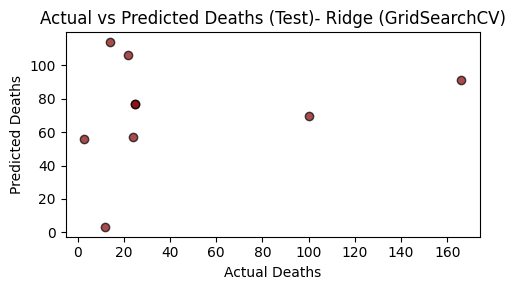

<Figure size 640x480 with 0 Axes>

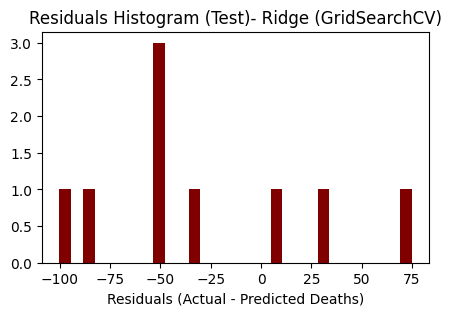


Ridge (GridSearchCV) predictions on unseen data (first 10):
            0
0  13.532337
1  13.532337
2  34.454835
3  34.454835
4  34.454835
5  -7.249519
6  -7.249519
7  33.986678
8  33.986678
9  33.986678

Lasso (GridSearchCV) best alpha: 24.42053
Lasso (GridSearchCV) Training R2 Score: 0.550
Lasso (GridSearchCV) Test R2 Score: -0.431
Lasso (GridSearchCV) Cross Val Score (R2): 0.179


<Figure size 640x480 with 0 Axes>

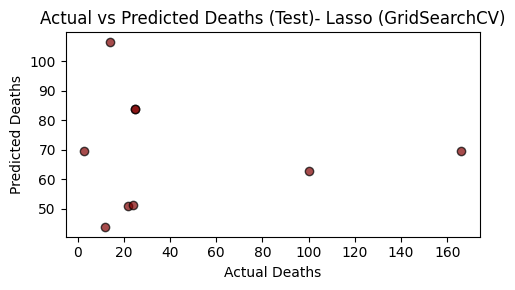

<Figure size 640x480 with 0 Axes>

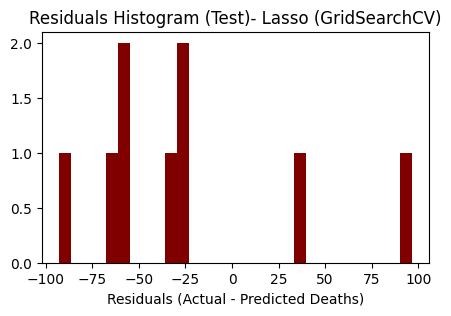


Lasso (GridSearchCV) predictions on unseen data (first 10):
            0
0  44.105277
1  44.105277
2  45.693165
3  45.693165
4  45.693165
5  44.193723
6  44.193723
7  47.667240
8  47.667240
9  47.667240



<Figure size 640x480 with 0 Axes>

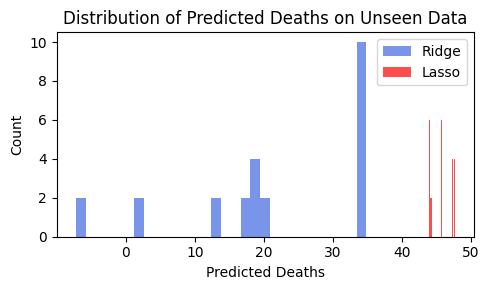

<Figure size 640x480 with 0 Axes>

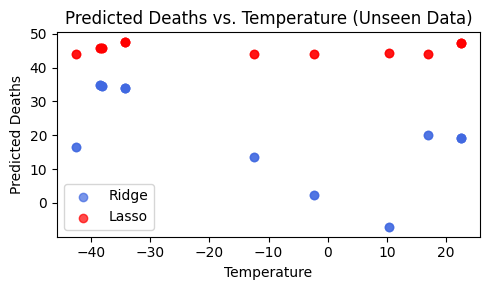

<Figure size 640x480 with 0 Axes>

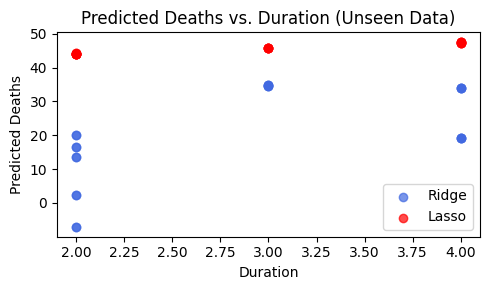

<Figure size 640x480 with 0 Axes>

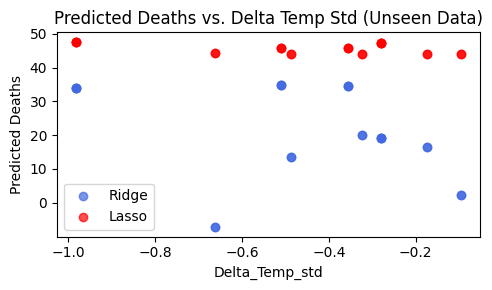


Evaluation metrics summary:


,Ridge (GridSearchCV),Lasso (GridSearchCV)
Best Alpha,11.513954,24.420531
Train R2,0.664363,0.549642
Test R2,-0.424288,-0.431328
CV R2,-0.074033,0.178545
MAE,54.346048,55.392709
MSE,3675.963356,3694.132968
RMSE,60.629723,60.779379


<Figure size 640x480 with 0 Axes>

In [9]:
features = ['temperature', 'duration', 'latitude', 'longitude', 'delta_temp_std']
X = features
y = 'total_deaths'

fit_and_evaluate_ridge_lasso_on_unseen(cold_final, cold_events_renamed, X, y, alpha_range = np.logspace(-4, 4, 50))

---
## Conclusion
#### Again confirmation that Ridge and Lasso did not make for very good models.

To test the unseen test data, we used Model 6, whereby the:
Features are temperature, duration, latitude, longitude, delta_temp_std.
Alpha range is log(-4,, 4, 50)
